#Image analysis

In [8]:
import glob as gl
import cv2
import numpy as np
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

import pylab
import pandas as pd

In [9]:
files = gl.glob('data/raw data/*.jpg')

In [10]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)


# Kmeans 
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = np.zeros([h*w,3], dtype=np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x][y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

In [11]:
df = pd.DataFrame(columns=['filename', 'number of particles', 'average particle size', 'image coverage'])

particles = []
size = []
coverage = []

for f in files:
    # Load image
    image = cv2.imread(f)
    original = image.copy()

    # Perform kmeans color segmentation, grayscale, Otsu's threshold
    kmeans = kmeans_color_quantization(image, clusters=2)
    gray = cv2.cvtColor(kmeans, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours, remove tiny specs using contour area filtering, gather points
    points_list = []
    size_list = []
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    AREA_THRESHOLD = 1
    image_area = image.shape[0] * image.shape[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < AREA_THRESHOLD:
            cv2.drawContours(thresh, [c], -1, 0, -1)
        else:
            (x, y), radius = cv2.minEnclosingCircle(c)
            points_list.append((int(x), int(y)))
            size_list.append(area)

    # Apply mask onto original image
    result = cv2.bitwise_and(original, original, mask=thresh)
    result[thresh==255] = (36,255,12)

    # Overlay on original
    original[thresh==255] = (36,255,12)

    #print("Number of particles: {}".format(len(points_list)))
    #print("Average particle size: {:.3f}".format(sum(size_list)/len(size_list)))
    #print("Image_coverage: {:.3f}".format(sum(size_list)/image_area))

    particles.append(len(points_list))
    size.append(sum(size_list)/len(size_list))
    coverage.append(sum(size_list)/image_area)

    #save_images
    cv2.imwrite('data/processed data/original/{}'.format(f.split('/')[-1]), original)
    cv2.imwrite('data/processed data/kmeans/{}'.format(f.split('/')[-1]), kmeans)
    cv2.imwrite('data/processed data/thresh/{}'.format(f.split('/')[-1]), thresh)
    cv2.imwrite('data/processed data/result/{}'.format(f.split('/')[-1]), result)
    cv2.imwrite('data/processed data/gray/{}'.format(f.split('/')[-1]), gray)

df['filename'] = [f.split('/')[-1] for f in files]
df['number of particles'] = particles
df['average particle size'] = size
df['image coverage'] = coverage

df.to_csv('data/data.csv', index=False)

#Data analyisis

In [1]:
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv('data/data.csv')

sample_names = df.filename.str.replace('.jpg','').str.split(r"[0-9]{2}[\ ]", expand=True, regex=True)[1].str.split('-', expand=True)
df['sample'] = sample_names[0].replace(' ', '')
df['rep'] = sample_names[1].astype(np.int64)


In [35]:
results = df.drop(columns='filename').groupby('sample').mean()
results

,number of particles,average particle size,image coverage,rep
sample,,,,
250211A1,641.600000,1742.291479,0.429917,3.0
250211A2,402.800000,16585.560366,0.713326,3.0
250211A3,446.166667,17084.349950,0.589685,3.5
250211A4,213.833333,47791.538610,0.772563,3.5
250211A5,1631.800000,935.875783,0.518217,3.0
250211A6,627.833333,2085.377108,0.510667,3.5
250211A7,734.333333,4547.864991,0.861187,3.5
250211A8,913.500000,6427.641582,0.851907,2.5
250211B1,1534.166667,1302.054525,0.487725,3.5


**Check images**

In [36]:
import glob as gl
import matplotlib.pyplot as plt

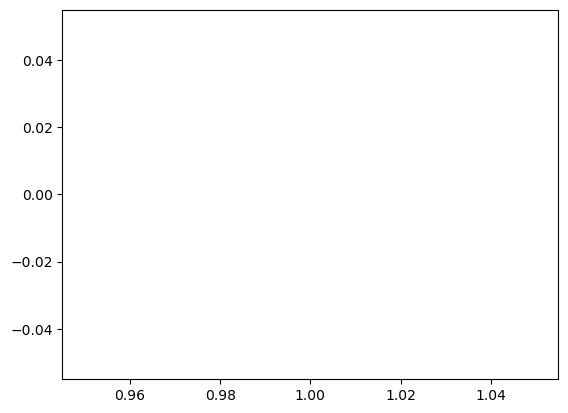

In [ ]:
def create_figure(name_file):
    gray_file = 'data/processed data/original/{}'.format(f.split('/')[-1]), original
